In [0]:
!pip install mpnum
import numpy as np
import matplotlib.pyplot as plt
import mpnum as mp
import mpnum.povm as mpp
import functools
import scipy
from mpnum.utils.array_transforms import local_to_global
import os
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':24})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('xtick', labelsize=24)
rc('ytick', labelsize=24)

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Tools for data generation (based on mpnum).

In [0]:
x = np.array([[0, 1], [1, 0]], dtype=np.complex64)
y = np.array([[0, -1j], [1j, 0]], dtype=np.complex64)
z = np.array([[1, 0], [0, -1]], dtype=np.complex64)
idm = np.eye(2)
sigma = np.array([x, y, z])
s = np.array([[0, 0, 1], [2 * np.sqrt(2)/3, 0, -1/3],\
              [-np.sqrt(2)/3, np.sqrt(2/3), -1/3],\
              [-np.sqrt(2)/3, -np.sqrt(2/3), -1/3]], dtype=np.complex64)

M = 0.25 * (idm + np.einsum('ij,jkl->ikl', s, sigma))
T = np.einsum('ijk,lkj->il', M, M)
T_inv = np.linalg.inv(T)
rng = np.random

zero = np.zeros((2, 2))

def ham(sites=3, ta=1., la=0.):
    
    h_mpo = mp.MPArray.from_kron([z, z])
    h = []
    
    for startpos in range(sites - 1):
        left = [mp.MPArray.from_kron([idm] * startpos)] if startpos > 0 else []
        right = [mp.MPArray.from_kron([idm] * (sites - 2 - startpos))] \
            if sites - 2 - startpos > 0 else []
        h_at_startpos = mp.chain(left + [h_mpo] + right)
        h.append(h_at_startpos)
        
    for startpos in range(sites):
        left = [mp.MPArray.from_kron([idm] * startpos)] if startpos > 0 else []
        right = [mp.MPArray.from_kron([idm] * (sites - 1 - startpos))] \
            if sites - 1 - startpos > 0 else []
        h_at_startpos = ta * mp.chain(left + [mp.MPArray.from_array_global(x)] + right)
        h.append(h_at_startpos)
        
    for startpos in range(sites):
        left = [mp.MPArray.from_kron([idm] * startpos)] if startpos > 0 else []
        right = [mp.MPArray.from_kron([idm] * (sites - 1 - startpos))] \
            if sites - 1 - startpos > 0 else []
        h_at_startpos = la * mp.chain(left + [mp.MPArray.from_array_global(z)] + right)
        h.append(h_at_startpos)
        
    H = h[0]
    for local_term in h:
        H = H + local_term
    return H
  
def corr_from_samples(samples, site1, site2, a, b):
    
    '''left = [mp.MPArray.from_kron([idm] * (site1 - 1))] if (site1 - 1) > 0 else []
    right = [mp.MPArray.from_kron([idm] * (samples.shape[1] - site2))] \
        if (samples.shape[1] - site2) > 0 else []
    mid = [mp.MPArray.from_kron([idm] * (site2 - site1 - 1))] \
        if (site2 - site1 - 1) > 0 else []

    mpo = mp.chain(left + [mp.MPArray.from_array_global(a)] + mid + \
             [mp.MPArray.from_array_global(b)] + right) if site1 != site2 else\
              mp.chain(left + [mp.MPArray.from_array_global(a.dot(b))]\
                       + right)
    T_inv_mpo = mp.MPArray.from_kron([T_inv] * samples.shape[1])
    povm = mp.MPArray.from_kron([M] * samples.shape[1])
    D = mp.dot(T_inv_mpo, povm, axes=(-1, 0)).transpose((0, 2, 1))
    D = D.reshape((4, 4))
    mpo_resh = mpo.reshape((4,))
    arr = mp.dot(D, mpo_resh, axes=(-1, 0))
    return np.array([mp.prune(arr.get(samples[i])).to_array() for i in range(samples.shape[0])]).sum() / samples.shape[0]'''
    left_term = np.einsum('ij,jkl,lk->i', T_inv, M, a)
    right_term = np.einsum('ij,jkl,lk->i', T_inv, M, b)
    mid_term = np.einsum('ij,jkl,lk->i', T_inv, M, a.dot(b))
    ind_left = samples[:, site1 - 1]
    ind_right = samples[:, site2 - 1]
    if site1 == site2:
        return np.array([mid_term[ind_left[i]] for i in range(samples.shape[0])]).sum() / samples.shape[0]
    else:
        return (np.array([left_term[ind_left[i]] for i in range(samples.shape[0])]) *\
        np.array([right_term[ind_right[i]] for i in range(samples.shape[0])])).sum() / samples.shape[0]
    
    
class ising_chain():
  
    def __init__(self, sites, ta=1, la=0):
      
        self.h = ham(sites, ta, la)
        self.psi = None
        self.sites = sites
        self.povm = mpp.mppovm.MPPovm.from_local_povm(M, width=sites)
        self.sampler = None
        
    def gs(self, num_sweeps=5, rank=25):
        
        eigs = functools.partial(scipy.sparse.linalg.eigsh, k=1, tol=1e-6, which='SA')
        _, self.psi = mp.linalg.eig(self.h, num_sweeps=num_sweeps, startvec_rank=rank, eigs=eigs)
        
    def corr(self, site1, site2, a, b):
        
        left = [mp.MPArray.from_kron([idm] * (site1 - 1))] if (site1 - 1) > 0 else []
        right = [mp.MPArray.from_kron([idm] * (self.sites - site2))] \
            if (self.sites - site2) > 0 else []
        mid = [mp.MPArray.from_kron([idm] * (site2 - site1 - 1))] \
            if (site2 - site1 - 1) > 0 else []
        
        mpo = mp.chain(left + [mp.MPArray.from_array_global(a)] + mid + \
                 [mp.MPArray.from_array_global(b)] + right) if site1 != site2 else\
                  mp.chain(left + [mp.MPArray.from_array_global(a.dot(b))]\
                           + right)
        
        return mp.dot(mp.dot(self.psi.conj(), mpo), self.psi).to_array()
      
    def sample(self, n):
        
        return self.povm.sample(rng, self.psi, n, method='cond', n_group=1, mode='auto', pack=False, eps=1e-10)

# Diagonalization of the model

In [0]:
model = ising_chain(25)
model.gs()

/usr/local/lib/python3.6/dist-packages/mpnum/mparray.py:1859: ComplexWarning: Casting complex values to real discards the imaginary part
  res[pos_l:pos_l_new, ..., pos_r:pos_r_new] = lt


# Data generation

In [0]:
import time
start_time = time.time()
samples = model.sample(10000)
np.save("/content/gdrive/My Drive/small_rg_data.npy", samples)
time.time() - start_time

1093.0073947906494

# Corr. func. plotting: exact and samples based

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


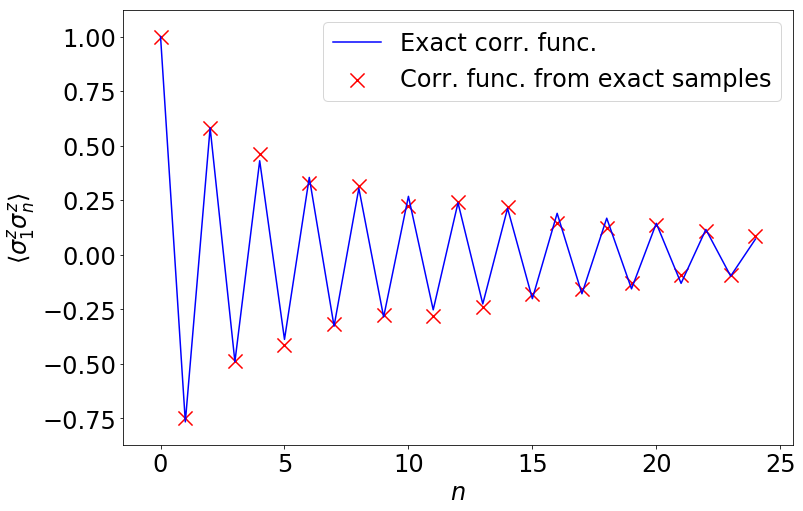

In [125]:
samples = np.load("/content/gdrive/My Drive/small_rg_data.npy")
fig = plt.figure(figsize=(12, 8))
plt.xlabel(r'$n$')
plt.ylabel(r'$\langle\sigma_1^{z}\sigma_n^{z}\rangle$')
plt.plot([model.corr(1, i, z, z) for i in range(1, 26)], 'b')
plt.scatter(np.arange(0, 25), [corr_from_samples(samples, 1, i, z, z) for i in range(1, 26)], marker='x', color='red', s=200)
plt.legend(['Exact corr. func.', 'Corr. func. from exact samples'])

#ResNet blocks for the encoder and decoder

In [0]:
import tensorflow as tf
import tensorflow.keras as K

def res_block_tr(inp, filters, ker_size):
    
    h0 = K.layers.Conv2DTranspose(filters=filters, kernel_size=(ker_size, 1), strides=1, padding='same', activation='elu')(inp)
    h1 = K.layers.Conv2DTranspose(filters=filters, kernel_size=(ker_size, 1), strides=1, padding='same', activation='elu')(h0)
    out = K.layers.Conv2DTranspose(filters=filters, kernel_size=(ker_size, 1), strides=1, padding='same', activation='elu')(h1)
    
    return out + h0
  
def res_block(inp, filters, ker_size):
    
    h0 = K.layers.Conv1D(filters=filters, kernel_size=ker_size, strides=1, padding='same', activation='elu')(inp)
    h1 = K.layers.Conv1D(filters=filters, kernel_size=ker_size, strides=1, padding='same', activation='elu')(h0)
    out = K.layers.Conv1D(filters=filters, kernel_size=ker_size, strides=1, padding='same', activation='elu')(h1)
    
    return out + h0

# Encoder and Decoder

In [115]:
tf.reset_default_graph()

with tf.name_scope('decoder'):
    
    inp = K.Input(shape=(5,), dtype=tf.float32)
    h1 = K.layers.Dense(16, activation='elu')(inp)
    h2 = K.layers.Dense(32, activation='elu')(h1)
    
    h3 = K.layers.Reshape((1, 1, 32))(h2)
    h4 = K.layers.UpSampling2D(size=(5, 1))(h3)
    
    h5 = res_block_tr(h4, 32, 2)
    h6 = res_block_tr(h5, 16, 2)

    h7 = K.layers.UpSampling2D(size=(5, 1))(h6)
    
    h8 = res_block_tr(h7, 8, 5)
    h9 = res_block_tr(h8, 4, 5)
    
    out = K.layers.Reshape((25, 4))(h9)
    
    decoder = K.Model(inputs=inp, outputs=out)
    
with tf.name_scope('encoder'):
    
    inp = K.Input(shape=(25, 4), dtype=tf.float32)
    
    h0 = res_block(inp, 4, 5)
    h1 = res_block(h0, 8, 5)
    
    h2 = K.layers.MaxPool1D(pool_size=5)(h1)
    
    h3 = res_block(h2, 16, 2)
    h4 = res_block(h3, 32, 2)
    
    h5 = K.layers.MaxPool1D(pool_size=5)(h4)
    h6 = K.layers.Reshape((32,))(h5)
    
    h7 = K.layers.Dense(32, activation='elu')(h6)
    h8 = K.layers.Dense(16, activation='elu')(h7)
    h9 = K.layers.Dense(10, activation=None)(h8)
    
    out = K.layers.Reshape((2, 5))(h9)
    encoder = K.Model(inputs=inp, outputs=out)

'''with tf.name_scope('decoder'):
    
    inp = K.Input(shape=(5,), dtype=tf.float32)
    h1 = K.layers.Dense(16, activation='elu')(inp)
    h2 = K.layers.Dense(32, activation='elu')(h1)
    
    h3 = K.layers.Reshape((1, 1, 32))(h2)
    h4 = K.layers.UpSampling2D(size=(5, 1))(h3)
    
    h5 = K.layers.Conv2DTranspose(filters=32, kernel_size=(2, 1), strides=1, padding='same', activation='elu')(h4)
    h6 = K.layers.Conv2DTranspose(filters=32, kernel_size=(2, 1), strides=1, padding='same', activation='elu')(h5)
    h7 = K.layers.Conv2DTranspose(filters=16, kernel_size=(2, 1), strides=1, padding='same', activation='elu')(h6)
    
    skip1 = K.layers.Conv2DTranspose(filters=16, kernel_size=(1, 1), strides=1, padding='same', activation='elu')(h4)
    
    h8 = K.layers.UpSampling2D(size=(5, 1))(h7 + skip1)
    
    h9 = K.layers.Conv2DTranspose(filters=16, kernel_size=(5, 1), strides=1, padding='same', activation='elu')(h8)
    h10 = K.layers.Conv2DTranspose(filters=16, kernel_size=(5, 1), strides=1, padding='same', activation='elu')(h9)
    h11 = K.layers.Conv2DTranspose(filters=4, kernel_size=(5, 1), strides=1, padding='same', activation=None)(h10)
    
    skip2 = K.layers.Conv2DTranspose(filters=4, kernel_size=(1, 1), strides=1, padding='same', activation='elu')(h8)
    
    out = K.layers.Reshape((25, 4))(h11 + skip2)
    decoder = K.Model(inputs=inp, outputs=out)
    
with tf.name_scope('encoder'):
    
    inp = K.Input(shape=(25, 4), dtype=tf.float32)
    h0 = K.layers.Conv1D(filters=16, kernel_size=5, strides=1, padding='same', activation='elu')(inp)
    h1 = K.layers.Conv1D(filters=16, kernel_size=5, strides=1, padding='same', activation='elu')(h0)
    h2 = K.layers.Conv1D(filters=16, kernel_size=5, strides=1, padding='same', activation='elu')(h1)
    
    skip1 = K.layers.Conv1D(filters=16, kernel_size=1, strides=1, padding='same', activation='elu')(inp)
    
    h3 = K.layers.MaxPool1D(pool_size=5)(h2 + skip1)
    
    h4 = K.layers.Conv1D(filters=32, kernel_size=2, strides=1, padding='same', activation='elu')(h3)
    h5 = K.layers.Conv1D(filters=32, kernel_size=2, strides=1, padding='same', activation='elu')(h4)
    h6 = K.layers.Conv1D(filters=32, kernel_size=2, strides=1, padding='same', activation='elu')(h5)
    
    skip2 = K.layers.Conv1D(filters=32, kernel_size=1, strides=1, padding='same', activation='elu')(h3)
    
    h7 = K.layers.MaxPool1D(pool_size=5)(h6 + skip2)
    h8 = K.layers.Reshape((32,))(h7)
    
    h9 = K.layers.Dense(32, activation='elu')(h8)
    h10 = K.layers.Dense(16, activation='elu')(h9)
    h11 = K.layers.Dense(10, activation=None)(h10)
    
    out = K.layers.Reshape((2, 5))(h11)
    encoder = K.Model(inputs=inp, outputs=out)'''

'''with tf.name_scope('decoder'):
    inp = K.Input(shape=(5,), dtype=tf.float32)
    h1 = K.layers.Dense(10, activation='elu')(inp)
    h2 = K.layers.Dense(20, activation='elu')(h1)
    h3 = K.layers.Dense(20, activation='elu')(h2)
    h4 = K.layers.Dense(40, activation=None)(h3)
    out = K.layers.Reshape((10, 4))(h4)
    decoder = K.Model(inputs=inp, outputs=out)
    
with tf.name_scope('encoder'):
    inp = K.Input(shape=(10, 4), dtype=tf.float32)
    h0 = K.layers.Reshape((40,))(inp)
    h1 = K.layers.Dense(20, activation='elu')(h0)
    h2 = K.layers.Dense(20, activation='elu')(h1)
    h3 = K.layers.Dense(10, activation='elu')(h2)
    h4 = K.layers.Dense(10, activation=None)(h3)
    out = K.layers.Reshape((2, 5))(h4)
    encoder = K.Model(inputs=inp, outputs=out)'''

"with tf.name_scope('decoder'):\n    inp = K.Input(shape=(5,), dtype=tf.float32)\n    h1 = K.layers.Dense(10, activation='elu')(inp)\n    h2 = K.layers.Dense(20, activation='elu')(h1)\n    h3 = K.layers.Dense(20, activation='elu')(h2)\n    h4 = K.layers.Dense(40, activation=None)(h3)\n    out = K.layers.Reshape((10, 4))(h4)\n    decoder = K.Model(inputs=inp, outputs=out)\n    \nwith tf.name_scope('encoder'):\n    inp = K.Input(shape=(10, 4), dtype=tf.float32)\n    h0 = K.layers.Reshape((40,))(inp)\n    h1 = K.layers.Dense(20, activation='elu')(h0)\n    h2 = K.layers.Dense(20, activation='elu')(h1)\n    h3 = K.layers.Dense(10, activation='elu')(h2)\n    h4 = K.layers.Dense(10, activation=None)(h3)\n    out = K.layers.Reshape((2, 5))(h4)\n    encoder = K.Model(inputs=inp, outputs=out)"

#Architecture of the encoder and decoder

In [128]:
encoder.summary()
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 25, 4)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 25, 4)        84          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 25, 4)        84          conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 25, 4)        84          conv1d_1[0][0]                   
____________________________________________________________________________________________

# VAE

In [0]:
x = tf.placeholder(shape=(None, 25), dtype=tf.int32, name='x')
eps = tf.placeholder(shape=(None, 5), dtype=tf.float32, name='eps')
learning_rate = 0.0005

with tf.name_scope('one_hot'):
    
    one_hot_x = tf.one_hot(x, axis=-1, depth=4)
    
with tf.name_scope('encode'):
    
    encoder_out = encoder(tf.cast(one_hot_x, dtype=tf.float32))
    mu = encoder_out[:, 0]
    log_s_sq = encoder_out[:, 1]
    
with tf.name_scope('decode'):
  
    log_probs = tf.nn.log_softmax(decoder(tf.sqrt(tf.exp(log_s_sq)) * eps + mu), axis=-1)
    
with tf.name_scope('loss'):
    
    loss = -tf.reduce_sum(one_hot_x * log_probs, axis=(1, 2))
    
with tf.name_scope('reg'):
    
    reg1 = 0.5 * tf.reduce_sum((tf.exp(log_s_sq) + mu ** 2), axis=-1)
    reg2 = -0.5 * tf.reduce_sum(log_s_sq + 1, axis=-1)
    
with tf.name_scope('full_loss'):
    
    full_loss = tf.reduce_mean(loss + reg2 + reg1)
    
with tf.name_scope('train'):
    
    train_step = tf.train.RMSPropOptimizer(learning_rate).minimize(full_loss)
    
################################################################################

sample = tf.nn.log_softmax(decoder(eps), axis=-1)

#Training

In [0]:
def batcher(data):
    
    np.random.shuffle(data)
    return [data[i:i + 1000] for i in range(10)]

batch_size = 1000

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
losses = []
for epoch in range(3000):
    l_abs = 0
    for batch in batcher(samples):
        l, _ = sess.run([full_loss, train_step], feed_dict={x:batch, eps:np.random.randn(batch_size, 5)})
        l_abs = l_abs + l
    losses.append(l_abs)

#Loss vs epochs

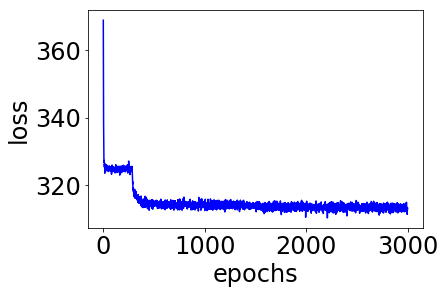

In [130]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(losses, 'b')

#Sampling from VAE

In [0]:
probs = sess.run(sample, feed_dict={eps:np.random.randn(100000, 5)})
samples_learned = (probs + np.random.gumbel(size=(probs.shape))).argmax(-1)

#Plotting: exact corr. fucn. vs samples based (exact and VAE) corr. func.

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


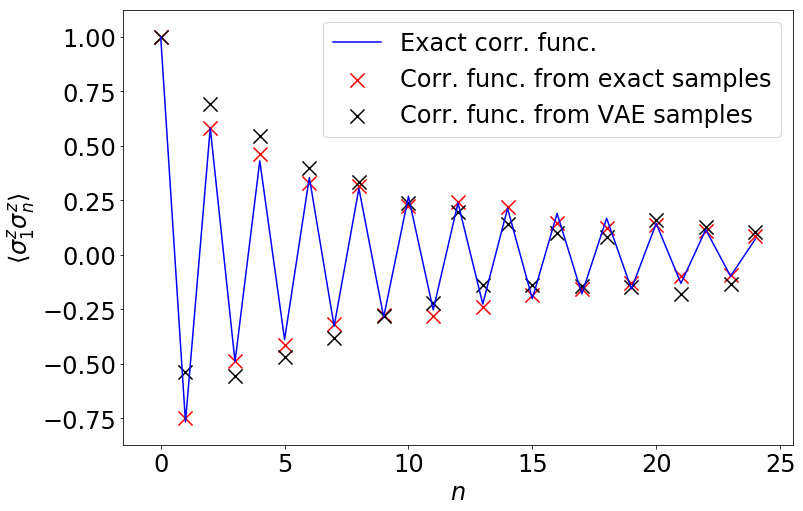

In [127]:
fig = plt.figure(figsize=(12, 8))
plt.xlabel(r'$n$')
plt.ylabel(r'$\langle\sigma_1^{z}\sigma_n^{z}\rangle$')
plt.plot([model.corr(1, i, z, z) for i in range(1, 26)], 'b')
plt.scatter(np.arange(0, 25), [corr_from_samples(samples, 1, i, z, z) for i in range(1, 26)], marker='x', color='red', s=200)
plt.scatter(np.arange(0, 25), [corr_from_samples(samples_learned, 1, i, z, z) for i in range(1, 26)], marker='x', color='black', s=200)
plt.legend(['Exact corr. func.', 'Corr. func. from exact samples', 'Corr. func. from VAE samples'])
plt.savefig('/content/gdrive/My Drive/corr_func.pdf')